In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.models as models
import torch.nn.functional as F
import math


class GaussianKernel(nn.Module):

    def __init__(self, in_count: int, variance: float=1e-1, rho: float=1e-2):
        super(GaussianKernel, self).__init__()
        self.in_count = in_count
        # no. of inputs x [var_x, var_y, rho]
        raw_param = torch.ones(in_count, 3, dtype=torch.float32) * torch.tensor([variance, variance, rho], dtype=torch.float32)
        raw_param[:, :2] += torch.rand_like(raw_param[:, :2]) * 0.1
        self.covariance = torch.nn.Parameter(raw_param)
        self.covariance.requires_grad = True

    def get_gaussian_kernel(self, kernel_size=3, padding=1, channels=32) -> nn.Conv2d:
        # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
        x_coord = torch.arange(kernel_size)
        x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()
        xy_grid = xy_grid.view(1, kernel_size, kernel_size, 2).repeat([channels, 1, 1, 1])

        mean = (kernel_size - 1)/2.

        # Calculate the 2-dimensional gaussian kernel which is
        # the product of two gaussian distributions for two different
        # variables (in this case called x and y)
        det = self.covariance[:, 0] * self.covariance[:, 1] - torch.pow(self.covariance[:, 2], 2.0)
        det_sqrt = torch.sqrt(det)
        coeff = 1. / (2. * math.pi * det_sqrt)
        pos = xy_grid - mean
        # -0.5 * −𝑘∗((𝑢−𝑥)∗(𝑟ℎ𝑜∗(𝑢−𝑦)−𝑣𝑎𝑟𝑦∗(𝑢−𝑥))+(𝑢−𝑦)∗(𝑟ℎ𝑜∗(𝑢−𝑥)−𝑣𝑎𝑟𝑥∗(𝑢−𝑦)))
        k = 1 / det
        x = xy_grid[:, :, :, 0].permute(1, 2, 0)
        y = xy_grid[:, :, :, 1].permute(1, 2, 0)
        var_x, var_y, rho = self.covariance[:, 0], self.covariance[:, 1], self.covariance[:, 2]
        a = (mean-x)*(rho*(mean-y)-var_y*(mean-x))
        b = (mean-y)*(rho*(mean-x)-var_x*(mean-y))
        exponent = 0.5 * k * (a+b)
        gaussian_kernel = coeff * torch.exp(exponent)

        # Make sure sum of values in gaussian kernel equals 1.
        gaussian_kernel = (gaussian_kernel / torch.sum(gaussian_kernel, dim=[0, 1])).permute(2, 0, 1)

        # Reshape to 2d depthwise convolutional weight
        gaussian_kernel = gaussian_kernel.view(channels, 1, kernel_size, kernel_size)

        gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                    kernel_size=kernel_size, groups=channels, padding=padding,
                                    bias=False)

        gaussian_filter.weight.data = gaussian_kernel
        gaussian_filter.weight.requires_grad = True
        gaussian_filter = gaussian_filter.to(self.covariance.device)
        
        return gaussian_filter
    
    def forward(self, x):
        # x should be in the form of [N, C, H, W]
        filt = self.get_gaussian_kernel(channels=self.in_count)
        return filt(x)


In [2]:
import matplotlib.pyplot as plt

In [3]:
a = GaussianKernel(in_count=32, variance=0.5, rho=0.1)

In [4]:
k = a.get_gaussian_kernel()

In [5]:
one_kernel = k.weight.data[0, 0]

In [6]:
one_kernel

tensor([[0.0673, 0.1214, 0.0347],
        [0.1226, 0.3080, 0.1226],
        [0.0347, 0.1214, 0.0673]])

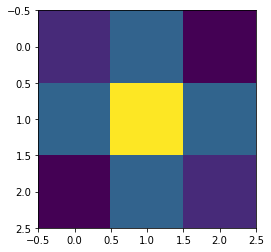

In [7]:
plt.imshow(one_kernel)

In [8]:
one_kernel = k.weight.data[1, 0]

In [9]:
one_kernel

tensor([[0.0688, 0.1214, 0.0377],
        [0.1241, 0.2959, 0.1241],
        [0.0377, 0.1214, 0.0688]])

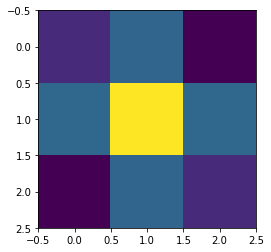

In [10]:
plt.imshow(one_kernel)